# BioBERT für RE

### Colaboratory einrichten

Für die nächsten Schritte müssen wir uns mit einer "hosted runtime" verbinden und unter "Runtime/Change Runtime Type" für "Hardware Accelerator" GPU auswählen.

Dann installieren wir uns:

In [1]:
!pip install transformers pytorch-nlp

     |████████████████████████████████| 389kB 9.3MB/s 
     |████████████████████████████████| 92kB 14.9MB/s 
     |████████████████████████████████| 675kB 72.5MB/s 
     |████████████████████████████████| 1.0MB 59.0MB/s 
     |████████████████████████████████| 860kB 52.3MB/s 
  Created wheel for regex: filename=regex-2019.12.9-cp36-cp36m-linux_x86_64.whl size=609182 sha256=64307a604a5a4b4c45e8acff6f114bcb0a4c6118d8d7b3846388b91f93a150b7
  Stored in directory: /root/.cache/pip/wheels/0d/fb/b3/a89169557229468c49ca64f6839418f22461f6ee0a74f342b1
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=50d09a3c5d5d16c8142a0777be6455236cabdee847412116afc44dfa41a87c07
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built regex sacremoses


Wenn GPU als Hardware Accelerator auswgewählt wurde, dann sollte folgendes klappen:

In [2]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Jetzt können wir entweder Colaboratory auf unser Google Drive zugreifen lassen oder wir laden die Korpusdateien selber hoch.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Step 1: BioBERT herunterladen und konvertieren

Als erstes müssen wir BioBERT herunterladen: [https://github.com/naver/biobert-pretrained](https://github.com/naver/biobert-pretrained)

Wir haben uns zunächst für die [BioBERT v1.1 (+ PubMed 1M)](https://drive.google.com/file/d/1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD/view) Version entschieden. In dem Archiv sind neben den TensorFlow Checkpoints, die BERT Konfiguration und das Vokabular enthalten.

Diese basiert auf der BERT Implementation von Google. Weil wir mit `huggingface` arbeiten wollen, haben wir den Tensorflow Checkpoint mit Hilfe der [`convert_tf_checkpoint_to_pytorch.py`](https://github.com/huggingface/transformers/blob/master/transformers/convert_tf_checkpoint_to_pytorch.py) Funktion in ein PyTorch Modell umgewandelt.

Siehe: [https://github.com/huggingface/transformers/issues/457#issuecomment-518403170](https://github.com/huggingface/transformers/issues/457#issuecomment-518403170)

```shell
export BERT_BASE_DIR=/path/to/bert/uncased_L-12_H-768_A-12

transformers bert \
  $BERT_BASE_DIR/model.ckpt-1000000 \
  $BERT_BASE_DIR/bert_config.json \
  $BERT_BASE_DIR/pytorch_model.bin
```
`BERT_BASE_DIR` ist der Pfad zu BioBERT.

Am besten erstellt man sich dann einen neuen Ordner, z.B. `biobert` und kopiert `pytorch_model.bin`, `bert_config.json` und `vocab.txt` dahin. Bei unserem ersten Test mussten wir `bert_config.json` und `config.json` umbenennen, damit wir später mit dem `transformers` Paket `biobert` laden konnten.


Ein kurzer Test, um zu schauen, ob wir unser BioBERT laden konnten:

In [0]:
from transformers import BertModel
biobert = '/content/drive/My Drive/TransferLearning/biobert_v1.1._pubmed'
model = BertModel.from_pretrained(biobert)

## Step 2: Imports und einige Einstellungen:

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

# Set the maximum sequence length. The longest sequence in our training set is 881, but it seems like the sentences were not split correctly. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 512

Jetzt greifen wir auf unsere Trainingsdateien zu, die wir mit `Korpusdaten-Bearbeiten.iypnb` vorbereitet haben.

In [0]:
# Paths if Google Drive was mounted
lin_aimed_path = "/content/drive/My Drive/TransferLearning/Trainingsdaten/lin_aimed_train.tsv" 
lin_bioinfer_path = "/content/drive/My Drive/TransferLearning/Trainingsdaten/lin_bioinfer_train.tsv"

ali_aimed_path = "/content/drive/My Drive/TransferLearning/Trainingsdaten/ali_aimed_train.tsv"
ali_bioinfer_path = "/content/drive/My Drive/TransferLearning/Trainingsdaten/ali_bioinfer_train.tsv"

lee_aimed_path = "/content/drive/My Drive/TransferLearning/Trainingsdaten/lee_aimed_train.tsv"
lee_bioinfer_path = "/content/drive/My Drive/TransferLearning/Trainingsdaten/lee_bioinfer_train.tsv"

## Step 3: Einmal testweise BERT Fine-Tuning Sentence Classification ausführen
Um mal zu schauen, ob es überhaupt klappt, führen wir den Code des Tutorials auf den AIMed Korpus mit Anonymisierung der Entitäten nach Lee et al durch.

In [7]:
df_lee_aimed = pd.read_csv(lee_aimed_path, delimiter='\t', header=None, names=['id', 'sentence', 'label'])
df_lee_bioinfer = pd.read_csv(lee_bioinfer_path, delimiter='\t', header=None, names=['id', 'sentence', 'label'])

df_lee_aimed.sample(5)
#df_lee_bioinfer.sample(5)

,id,sentence,label
688,AIMed.d43.s376.p1,"In this study, a minimum set of residues in th...",0
4549,AIMed.d216.s1875.p0,An arginine side chain (arginine-789) of @PROT...,0
470,AIMed.d37.s315.p18,"We found that in addition to MIP-1beta, MIP-1a...",0
3173,AIMed.d163.s1374.p5,"A protein, sorting nexin-1 (SNX1), was identif...",0
1460,AIMed.d90.s767.p0,Using radiolabeled @PROTEIN$ protein as a prob...,0


Wir müssen die Paare nach Sätzen oder Dokumenten sammeln, um dann entsprechend zu splitten. Da wir momentan den Train-Dev-Test Split auf den Paaren machen, besteht die Gefahr, dass unser Modell einen Testsatz bereits während des Trainings gesehen hat.

(Alternativ kann man das auch schon bei der Korpusverarbeitung machen...)

Data analysis

In [0]:
aimed_sents = None
bioinfer_sents = None

AIMed Pair 36 has longest length 881
RESULTS: After 7 days hospitalisation, molar @PROTEIN$:@PROTEIN$ ratio (mean+/-s.d.) of infected children (C-reactive proteins>10 mg/l) was 0.67+/-0.31 in the high-dose group (n=81), 0.74+/-0.44 in the low dose group (n=71) and 0.73+/-0.39 in the placebo group (n=81). These values did not differ significantly (one-way ANOVA P=0.472). In patients with baseline serum retinol concentrations<0.70 micromol/l, changes in RBP:TTR ratio between admission and day 7 were not statistically different in the three groups (one-way ANOVA P=0.548). CONCLUSIONS: In this population of malnourished hospitalised children, molar RBP:TTR ratio does not appear to be useful to assess VA status during infection. SPONSORSHIP: Our research was partially supported by a grant from the Fonds de la Recherche Scientifique et Medicale (contract 3.4505.94) and the David and Alice Van Buuren Foundation.
BioInfer Pair 7180 has longest length 635
The undifferentiated cells (a) were una

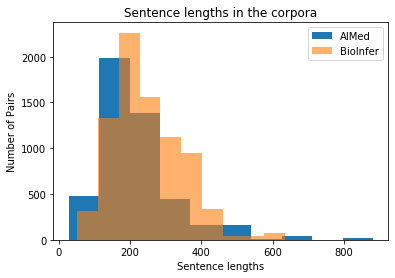

In [21]:
aimed_sent_lengths = df_lee_aimed.sentence.map(lambda x: len(x))
print("AIMed Pair", aimed_sent_lengths.idxmax(), "has longest length", aimed_sent_lengths.max())  # max length 881 , 36th pair
print(df_lee_aimed.sentence[36])

bioinfer_sent_lengths = df_lee_bioinfer.sentence.map(lambda x: len(x))  
print("BioInfer Pair", bioinfer_sent_lengths.idxmax(), "has longest length", bioinfer_sent_lengths.max())  # max length 635, 7180th pair
print(df_lee_bioinfer.sentence[7180])

fig = plt.figure()
plt.hist(aimed_sent_lengths, label='AIMed')
plt.hist(bioinfer_sent_lengths, label='BioInfer', alpha=0.6)

plt.xlabel('Sentence lengths')
plt.ylabel('Number of Pairs')

plt.title("Sentence lengths in the corpora")

plt.legend()

plt.show()

In [0]:
# Create sentence and label lists

df_list = [df_lee_aimed, df_lee_bioinfer]

sentences = []
labels = []
for df in df_list:
  sentences.extend(df.sentence.values)
  labels.extend(df.label.values)

In [0]:
# Import BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(biobert, do_lower_case=True)
special_token_dict = {'additional_special_tokens': ['@PROTEIN$']}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
print('Added {} tokens'.format(num_added_tokens))

# Adding the special tokens before tokenization seems to destroy them
input_ids = [tokenizer.encode(sent, add_special_tokens=True, max_length=MAX_LEN) for sent in sentences]

In [0]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


In [0]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

print(attention_masks[:2])

# Use train_test_split to split our data into train and test sets
# and train_test_split again to split test set into validation and test sets
# Split: 0.8, 0.1, 0.1

train_inputs, tmp_inputs, train_labels, tmp_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.2)
validation_inputs, test_inputs, validation_labels, test_labels = train_test_split(tmp_inputs, tmp_labels, 
                                                            random_state=2018, test_size=0.5)

train_masks, tmp_masks, _, tmp_ids = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.2)
validation_masks, test_masks, _, _ = train_test_split(tmp_masks, tmp_ids,
                                             random_state=2018, test_size=0.5)

# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
test_inputs = torch.tensor(test_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks = torch.tensor(test_masks)

# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

Fine-Tuning

In [0]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained(biobert, num_labels=2)
model.cuda()
model.resize_token_embeddings(len(tokenizer))

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

# Parameters:
lr = 2e-5

# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=lr)

Methoden, um die Performance unseres Modells auf den Validation & Testdaten zu messen.

In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Function to calculate the precision of our predictions vs labels: TP/(TP+FP)
def flat_precision(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    # Collect comparison value for all the times that our model predicted 1
    positives = [pred == gold for pred, gold in zip(pred_flat,labels_flat) if pred == 1]
    tp = sum(positives)
    fp = len(positives) - tp
    return tp / (tp + fp)

# Function to calculate the recall of our predictions vs labels: TP/(TP+FN)
def flat_recall(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    tp_and_fn = labels_flat.sum()
    # Collect comparison value for all the times that our model predicted 1
    tp = sum([pred == gold for pred, gold in zip(pred_flat,labels_flat) if pred == 1])

    return tp / tp_and_fn

def f1_score(precision, recall):
  return 2.0*precision*recall/(precision+recall)

In [0]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss, logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = output[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.4295140661789706


Epoch:  25%|██▌       | 1/4 [04:09<12:29, 249.89s/it]

Validation Accuracy: 0.8348958333333334
Train loss: 0.2478213500009622


Epoch:  50%|█████     | 2/4 [08:19<08:19, 249.83s/it]

Validation Accuracy: 0.90703125
Train loss: 0.14256813861780032


Epoch:  75%|███████▌  | 3/4 [12:29<04:09, 249.77s/it]

Validation Accuracy: 0.9010416666666666
Train loss: 0.08938066721499714


Epoch: 100%|██████████| 4/4 [16:38<00:00, 249.75s/it]

Validation Accuracy: 0.9385416666666666


Training Evaluation

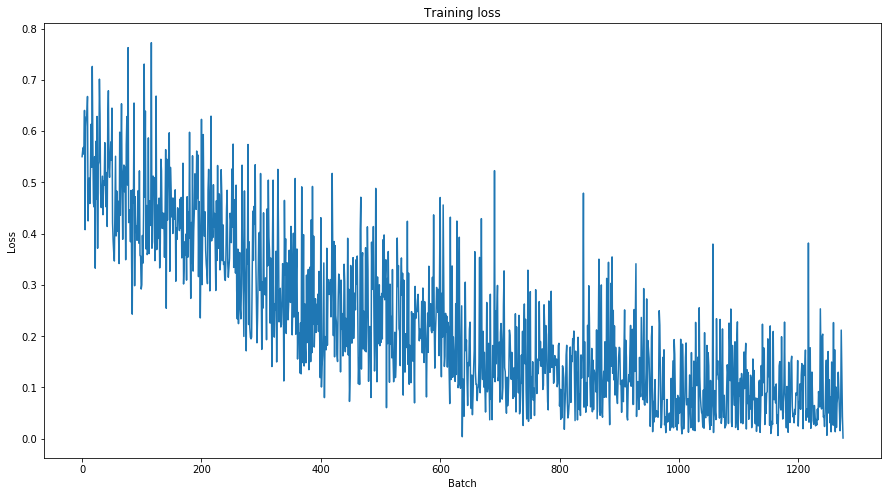

In [0]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [0]:
prediction_data = TensorDataset(test_inputs, test_masks, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []
eval_accuracy = 0
nb_eval_steps, nb_eval_examples = 0, 0

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = output[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

  tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
  eval_accuracy += tmp_eval_accuracy
  nb_eval_steps += 1

print("Test Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Test Accuracy: 0.9294687500000001


In [0]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

In [0]:
matthews_set

[0.8132500607904443,
 0.9229582069908973,
 0.28888888888888886,
 0.8459051693633014,
 0.9229582069908973,
 0.7624437362098716,
 0.6070347255016324,
 0.9278305692406299,
 0.6050580452280905,
 0.9229582069908973,
 0.7867957924694432,
 0.9078412990032037,
 0.8643121965600912,
 0.8783100656536799,
 1.0,
 0.7419408268023742,
 0.6880212116344248,
 0.8096598849105344,
 0.8563488385776753,
 0.8783100656536799,
 0.6050580452280905,
 0.8333333333333334,
 0.7141684885491869,
 0.5204956780951701,
 0.7141684885491869,
 0.762962962962963,
 0.8333333333333334,
 0.9229582069908973,
 0.8320502943378436,
 0.9278305692406299,
 0.717973623597536,
 0.5584155773160767,
 1.0,
 0.7848566748139434,
 0.52678658400752,
 0.8783100656536799,
 0.9078412990032037,
 1.0,
 0.8666666666666667,
 0.901127113779166]

In [0]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
matthews_corrcoef(flat_true_labels, flat_predictions)

0.8077795876047339

Wir schauen uns die Performance-Maße für unser Modell auf den Testdaten an:

In [0]:
acc, precision, recall = 0.0, 0.0, 0.0
# Get macro averaged values
for preds, gold_labels in zip(predictions, true_labels):
  acc += flat_accuracy(preds,gold_labels)
  precision += flat_precision(preds,gold_labels)
  recall += flat_recall(preds,gold_labels)
acc /= len(predictions)
precision /= len(predictions)
recall /= len(predictions)

f1 = f1_score(precision, recall)

print("Accuracy: {:.03f}".format(acc))
print("Precision: {:.03f}".format(precision))
print("Recall: {:.03f}".format(recall))
print("F1 score: {:.03f}".format(f1))

Accuracy: 0.929
Precision: 0.831
Recall: 0.862
F1 score: 0.846


Modell abspeichern:

In [0]:
torch.save(model.state_dict(), '/content/drive/My Drive/TransferLearning/best_checkpoint.pth')

Später folgendermaßen laden
```python
the_model = TheModelClass(*args, **kwargs)
the_model.load_state_dict(torch.load(PATH))
```